# X-RAY 이미지로 폐렴 진단 보조하기

캐글의 Chest X-Ray Images로 폐렴을 진단하는 model을 만들어 보겠습니다. 데이터셋은 총 5856장의 JPEG 이미지로 이루어져 있습니다. 

## import modules

In [98]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

전역 변수를 설정합니다.

In [99]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## load data

In [100]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


validation이 너무 적은 것을 알 수 있습니다. train과 val을 묶어 8:2로 무작위 추출하여 새로이 train과 val로 저장합니다.

In [101]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


경로에 NORMAL과 PNEUNOMIA가 포함되었는지 여부로 양성/음성을 분류합니다.

In [102]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0582-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person313_bacteria_1457.jpeg


이미지 개수를 살펴봅니다. 폐렴 이미지가 약 3배인 것을 알 수 있습니다.

In [103]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


train, val을 각각 Dataset 객체로 만듭니다.

In [104]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [105]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [106]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

tf.image.decode_jpeg를 사용합니다. 이미지를 uint8형식으로 바꿉니다. channels=3은 RGB 이미지를 반환한다는 의미입니다. 이후 labeling과, resizing을 진행합니다.

In [107]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [108]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [109]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


test에 대해서도 같은 처리를 하고, BATCH_SIZE로 분할합니다.

In [110]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


효율적 학습을 위해 Dataset 객체의 여러 메소드를 사용합니다.
shuffle - 버퍼에서 무작위로 추출합니다.
repeat - 샘플을 n 번 사용합니다. n이 주어지지 않으면 계속 반복됩니다.
prefetch - 버퍼가 소진될 때를 대비해 fetch할 값을 정합니다.

In [111]:
def prepare_for_training(ds, shuffle_buffer_size=200):
    print(ds)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>
<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>


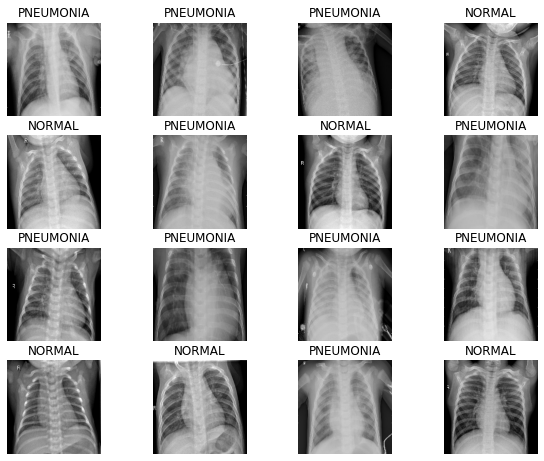

In [112]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [113]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [114]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [115]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

데이터의 클래스 간 불균형이 있는 데이터이므로, 뽑는 비율을 정해봅니다

In [116]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [121]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [123]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [124]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=15,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

    )

Epoch 1/15
261/261 [==============================] - 35s 118ms/step - loss: 0.5813 - accuracy: 0.6845 - precision: 0.8848 - recall: 0.6546 - val_loss: 0.5904 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 30s 115ms/step - loss: 0.2207 - accuracy: 0.9145 - precision: 0.9753 - recall: 0.9077 - val_loss: 0.8927 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 30s 116ms/step - loss: 0.2165 - accuracy: 0.9178 - precision: 0.9693 - recall: 0.9185 - val_loss: 0.3621 - val_accuracy: 0.8163 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 30s 116ms/step - loss: 0.1681 - accuracy: 0.9345 - precision: 0.9731 - recall: 0.9374 - val_loss: 0.2787 - val_accuracy: 0.9144 - val_precision: 0.9985 - val_recall: 0.8848
Epoch 5/15
261/261 [==============================] - 30s 116ms/step - loss: 0.1721 - accura

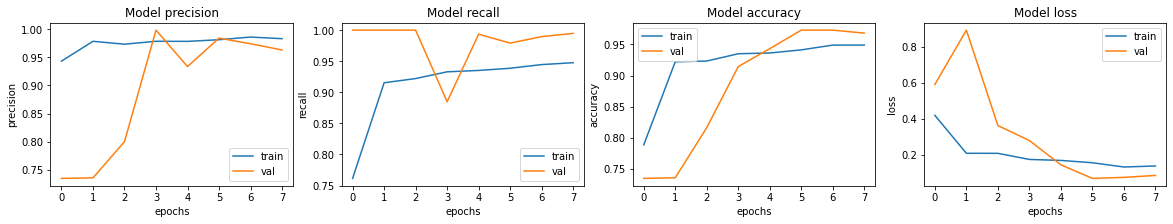

In [125]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [126]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 72ms/step - loss: 0.9999 - accuracy: 0.7179 - precision: 0.6897 - recall: 0.9974
Loss: 0.9999426007270813,
Accuracy: 0.7179487347602844,
Precision: 0.6897163391113281,
Recall: 0.9974358677864075


### 0.72의 baseline accuracy를 얻었습니다.

# Project

이제 모델을 개선해보겠습니다.

## import modules

In [127]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

전역 변수를 설정합니다.

In [128]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## load data

In [129]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


validation이 너무 적은 것을 알 수 있습니다. sample imbalance를 해결한 뒤 나누어주도록 하겠습니다

In [130]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))
trainval_filenames = filenames


print(len(trainval_filenames))

5232


경로에 NORMAL과 PNEUNOMIA가 포함되었는지 여부로 양성/음성을 분류합니다.

In [131]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1227-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person507_virus_1019.jpeg


이미지 개수를 살펴봅니다. 폐렴 이미지가 약 3배인 것을 알 수 있습니다.

In [132]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in trainval_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in trainval_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


In [133]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

tf.image.decode_jpeg를 사용합니다. 이미지를 uint8형식으로 바꿉니다. channels=3은 RGB 이미지를 반환한다는 의미입니다. 이후 labeling과, resizing을 진행합니다.

In [134]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [135]:
X_trainval = np.array([process_path(filename)[0] for filename in trainval_filenames])
y_trainval = np.array([process_path(filename)[1] for filename in trainval_filenames])

데이터셋이 imbalance이므로 sampling이 필요합니다. 이 함수는 각 클래스(0, 1)의 개수의 평균값 번 복원추출합니다.

In [136]:
def sample_to_balance(x, y):
    np.random.seed(42)
    num_to_sample = int(np.bincount(y.flatten()).mean()) # 클래스별 데이터 포인트 수의 평균
    all_sampled_inds = []
    for label in np.unique(y.flatten()): 
        inds = np.where(y == label)[0] # np.where은 tuple을 return합니다. 이때 첫번째가 답이 label인 index의 ndarray입니다.
        sampled_inds = np.unique(np.random.choice(inds, num_to_sample)) # index array에서 평균 번 sampling 후 중복을 제거합니다
        all_sampled_inds.append(sampled_inds)
    ind = np.concatenate(all_sampled_inds)
    x_sampled = x[ind]
    y_sampled = y[ind]
    return x_sampled, y_sampled

예시

In [137]:
sampled_X_train, sampled_y_train = sample_to_balance(np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]),\
                                                     np.array([0,0,1,1,1,1,1,1,1,1,1,1,1,1,1])) 

In [138]:
sampled_X_train, sampled_y_train = sample_to_balance(sampled_X_train,sampled_y_train) 

In [139]:
sampled_X_train

array([ 1,  2,  9, 13])

In [140]:
sampled_y_train

array([0, 0, 1, 1])

샘플링합니다

In [141]:
sampled_X_trainval, sampled_y_trainval = sample_to_balance(X_trainval, y_trainval)
sampled_X_trainval, sampled_y_trainval = sample_to_balance(sampled_X_trainval, sampled_y_trainval)

In [142]:
sampled_y_trainval.sum()/len(sampled_y_trainval)

0.5511425462459195

In [143]:
len(sampled_y_trainval)

1838

In [144]:
np.where(sampled_y_trainval==True)

(array([ 825,  826,  827, ..., 1835, 1836, 1837]),)

In [145]:
type(sampled_y_trainval)

numpy.ndarray

약 55: 45의 비율로 양성과 음성이 샘플링되었습니다. 이제 train/val을 나누고 dataset으로 만듭니다


https://towardsdatascience.com/building-efficient-data-pipelines-using-tensorflow-8f647f03b4ce

In [146]:
from sklearn.model_selection import train_test_split

In [147]:
sampled_X_train, sampled_X_val, sampled_y_train, sampled_y_val = train_test_split(sampled_X_trainval, sampled_y_trainval, \
                                                                                  test_size=0.2, random_state=42)

In [148]:
train_X = tf.data.Dataset.from_tensor_slices(sampled_X_train)
train_y = tf.data.Dataset.from_tensor_slices(sampled_y_train)

val_X = tf.data.Dataset.from_tensor_slices(sampled_X_val)
val_y = tf.data.Dataset.from_tensor_slices(sampled_y_val)

train_set = tf.data.Dataset.zip((train_X,train_y))
val_set = tf.data.Dataset.zip((val_X,val_y))

In [149]:
train_set = train_set.map(lambda x,y : (x,y), num_parallel_calls=AUTOTUNE)
val_set = val_set.map(lambda x,y : (x,y), num_parallel_calls=AUTOTUNE)

In [150]:
train_set

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>

In [151]:
TRAIN_IMG_COUNT = len(sampled_y_train)
VAL_IMG_COUNT = len(sampled_y_val)

print(TRAIN_IMG_COUNT, VAL_IMG_COUNT)

1470 368


test dataset도 만듭니다

In [152]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


다른 값은 그대로 둔 채로 학습해봅니다

In [153]:
train_set = prepare_for_training(train_set)

val_set = prepare_for_training(val_set)

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>
<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>


In [171]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [172]:
BATCH_SIZE=4

es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

                   
with tf.device('/GPU:0'):
    history = model.fit(
        train_set,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        validation_data=val_set,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callbacks = [es, model_checkpoint_callback])

Epoch 1/5
367/367 [==============================] - 36s 92ms/step - loss: 0.4426 - accuracy: 0.7978 - precision: 0.8278 - recall: 0.7897 - val_loss: 1.2451 - val_accuracy: 0.5489 - val_precision: 0.5489 - val_recall: 1.0000
Epoch 2/5
367/367 [==============================] - 33s 90ms/step - loss: 0.1591 - accuracy: 0.9446 - precision: 0.9452 - recall: 0.9543 - val_loss: 1.2232 - val_accuracy: 0.5516 - val_precision: 0.5504 - val_recall: 1.0000
Epoch 3/5
367/367 [==============================] - 33s 90ms/step - loss: 0.1416 - accuracy: 0.9423 - precision: 0.9443 - recall: 0.9509 - val_loss: 0.0684 - val_accuracy: 0.9701 - val_precision: 0.9799 - val_recall: 0.9653
Epoch 4/5
367/367 [==============================] - 33s 91ms/step - loss: 0.1345 - accuracy: 0.9492 - precision: 0.9456 - recall: 0.9603 - val_loss: 0.1556 - val_accuracy: 0.9429 - val_precision: 0.9132 - val_recall: 0.9901
Epoch 5/5
367/367 [==============================] - 33s 90ms/step - loss: 0.1116 - accuracy: 0.9614

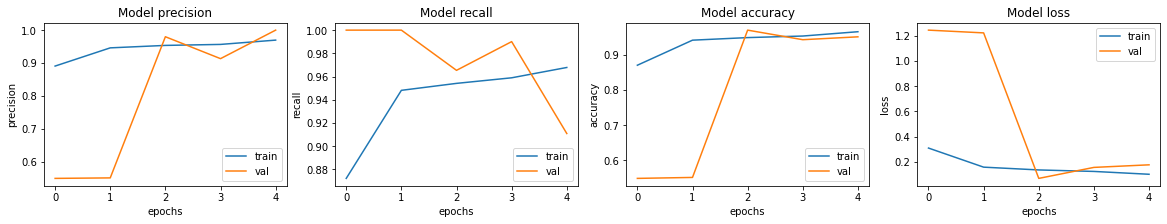

In [173]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [174]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 0.4208 - accuracy: 0.8814 - precision: 0.8780 - recall: 0.9410
Loss: 0.4207659959793091,
Accuracy: 0.8814102411270142,
Precision: 0.8779904246330261,
Recall: 0.9410256147384644


# 0.85이상의 정확도를 얻었습니다

#  회고

1️⃣ 잘한 점:

클래스 간 불균형을 줄여주는 함수를 만들어서 사용했습니다.

2️⃣ 어려웠던 점:

안정적인 학습을 구현하기 어려웠습니다. 늘 평가지표가 들쭉날쭉했습니다.
노드에서는 데이터셋 객체를 구현해서 활용했는데, 불균형을 줄이기 위해 만든 함수는 array를 입력으로 받는데, dataset에서 ndarray를 왔다갔다 하는 것이 어려웠습니다.


3️⃣ 느낀 점:

텐서플로는 너무 복잡한 규칙이 많고, 오히려 방해가 되는 느낌입니다. 만약 사용할거면 제대로 API내에서 사용하는 게 좋겠습니다.